In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
from sklearn.decomposition import PCA

from sklearn.metrics import roc_auc_score

In [3]:
def cov_and_mean(x, rowvar=False, bias=False, ddof=None, aweights=None):
    """Estimates covariance matrix like numpy.cov and also returns the weighted mean.

    Parameters:
    -----------
    x : torch.Tensor, shape [N, D]
        The tensor to estimate covariance of.
    rowvar : bool
        If given, columns are treated as observations.
    bias : bool
        If given, use correction for the empirical covariance.
    aweights : torch.Tensor, shape [N] or None
        Weights for each observation.
    
    Returns:
    --------
    cov : torch.Tensor, shape [D, D]
        Empirical covariance.
    mean : torch.Tensor, shape [D]
        Empirical means.

    References:
    -----------
    From: https://github.com/pytorch/pytorch/issues/19037#issue-430654869
    """
    # ensure at least 2D
    if x.dim() == 1:
        x = x.view(-1, 1)

    # treat each column as a data point, each row as a variable
    if rowvar and x.shape[0] != 1:
        x = x.t()

    if ddof is None:
        if bias == 0:
            ddof = 1
        else:
            ddof = 0

    w = aweights
    if w is not None:
        if not torch.is_tensor(w):
            w = torch.tensor(w, dtype=torch.float)
        w_sum = torch.sum(w)
        avg = torch.sum(x * (w/w_sum)[:,None], 0)
    else:
        avg = torch.mean(x, 0)

    # Determine the normalization
    if w is None:
        fact = x.shape[0] - ddof
    elif ddof == 0:
        fact = w_sum
    elif aweights is None:
        fact = w_sum - ddof
    else:
        fact = w_sum - ddof * torch.sum(w * w) / w_sum

    xm = x.sub(avg.expand_as(x))

    if w is None:
        X_T = xm.t()
    else:
        X_T = torch.mm(torch.diag(w), xm).t()

    c = torch.mm(X_T, xm)
    c = c / fact

    return c.squeeze(), avg


In [4]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [5]:
x = torch.load('features_debug.pt')

In [6]:
features_fit = x['features_fit']
pred_fit = x['predictions_fit']
labels_fit = x['labels_fit']
features_eval = x['features_eval']
pred_eval = x['predictions_eval']
labels_eval = x['labels_eval']

In [7]:
is_ood_label = labels_eval >= pred_eval.size(1)

In [8]:
means = torch.stack([features_fit[labels_fit == i].mean(0) for i in range(pred_fit.size(1))])
distances_to_mean = torch.cdist(features_eval, means)
distances_to_mean_s, _ = torch.sort(distances_to_mean, dim=-1)
distances_to_fit = torch.cdist(features_eval, features_fit)
distances_to_fit_s, _ = torch.sort(distances_to_fit, dim=-1)


In [9]:
means.size()

torch.Size([7, 64])

0.9838236337484922

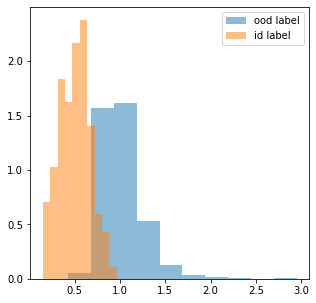

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(distances_to_mean[is_ood_label].min(-1)[0].numpy(), density=True, alpha=.5, label='ood label')
ax.hist(distances_to_mean[~is_ood_label].min(-1)[0].numpy(), density=True, alpha=.5, label='id label')
ax.legend()
roc_auc_score((~is_ood_label).numpy().astype(int), -distances_to_mean.min(-1)[0].numpy())

In [11]:
class_log_densities = []


0.9758515489451178

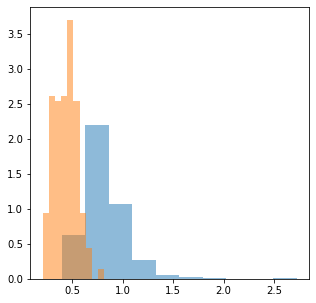

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(distances_to_fit_s[is_ood_label][:, :5].mean(-1).numpy(), density=True, alpha=.5, label='ood label')
ax.hist(distances_to_fit_s[~is_ood_label][:, :5].mean(-1).numpy(), density=True, alpha=.5, label='id label')
roc_auc_score((~is_ood_label).numpy().astype(int), -distances_to_fit_s[:, :5].min(-1)[0].numpy())

0.8892663876006993

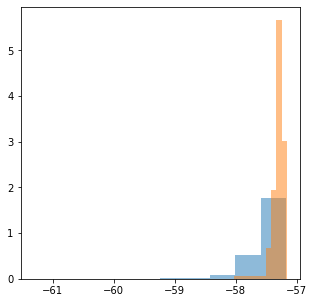

In [13]:
dists = [MultivariateNormal(means[i], covariance_matrix=torch.eye(64)) for i in range(pred_fit.size(1))]
log_probs = torch.stack([d.log_prob(features_eval) for d in dists]).T

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(torch.logsumexp(log_probs, 1)[is_ood_label].numpy(), density=True, alpha=.5, label='ood label')
ax.hist(torch.logsumexp(log_probs, 1)[~is_ood_label].numpy(), density=True, alpha=.5, label='id label')


roc_auc_score((~is_ood_label).numpy().astype(int), torch.logsumexp(log_probs, 1).numpy())

In [14]:
dists = [MultivariateNormal(means[i], covariance_matrix=covs[i] + 1e-8 * torch.eye(64)) for i in range(pred_fit.size(1))]
log_probs = torch.stack([d.log_prob(features_eval) for d in dists]).T

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(log_probs.max(1)[0][is_ood_label].numpy(), density=True, alpha=.5, label='ood label')
ax.hist(log_probs.max(1)[0][~is_ood_label].numpy(), density=True, alpha=.5, label='id label')
ax.legend()

roc_auc_score((~is_ood_label).numpy().astype(int), log_probs.max(1)[0].numpy())

NameError: name 'covs' is not defined

In [146]:
covs[2]

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [147]:
covs, means, norms = {}, {}, {}
for i in range(pred_fit.size(1)):
    covs[i], means[i] = cov_and_mean(features_fit[labels_fit == i])
    # covs[i] = torch.eye(64)
    norms[i] = MultivariateNormal(means[i], covariance_matrix=covs[i] * torch.eye(64), validate_args=False)
    

In [95]:
def density(h, norms, max_=False):
    log_densities = torch.stack([n.log_prob(h) for n in norms.values()])
    w = torch.ones(len(norms)).view(-1, 1)
    w /= len(norms)
    if max_:
        return torch.max(log_densities, 0)[0]
    else:
        return torch.logsumexp(log_densities + torch.log(w), 0)

(array([0.00475486, 0.00118872, 0.00237742, 0.00237743, 0.00237743,
        0.0071323 , 0.02020817, 0.05111447, 1.07222175, 0.46003306]),
 array([-65.      , -64.384155, -63.76831 , -63.152462, -62.536617,
        -61.920773, -61.304928, -60.689083, -60.073235, -59.45739 ,
        -58.841545], dtype=float32),
 <BarContainer object of 10 artists>)

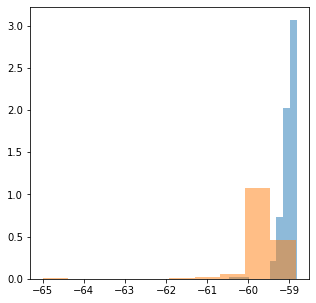

In [100]:
f, ax = plt.subplots(figsize=(5, 5))
ax.hist(torch.clamp(density(features_eval[labels_eval < pred_eval.size(1)], norms, max_=True), -65, -50).numpy(), alpha=.5, label='id', density=True)
ax.hist(torch.clamp(density(features_eval[labels_eval >= pred_eval.size(1)], norms, max_=True), -65, 50).numpy(), alpha=.5, label='ood', density=True)

(array([0.00158293, 0.        , 0.00158293, 0.        , 0.00158292,
        0.00237439, 0.00316586, 0.01662068, 0.11871961, 0.93551054]),
 array([-68.09105 , -67.1661  , -66.24115 , -65.3162  , -64.39125 ,
        -63.466297, -62.541348, -61.616398, -60.691444, -59.766495,
        -58.841545], dtype=float32),
 <BarContainer object of 10 artists>)

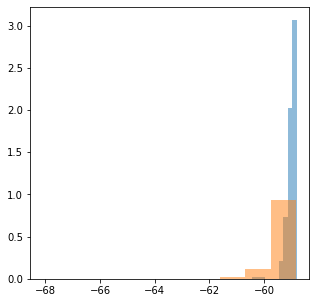

In [97]:
f, ax = plt.subplots(figsize=(5, 5))
ax.hist(torch.clamp(density(features_eval[labels_eval < pred_eval.size(1)], norms, max_=True), -200, 200).numpy(), alpha=.5, label='id', density=True)
ax.hist(torch.clamp(density(features_eval[labels_eval >= pred_eval.size(1)], norms, max_=True), -200, 200).numpy(), alpha=.5, label='ood', density=True)

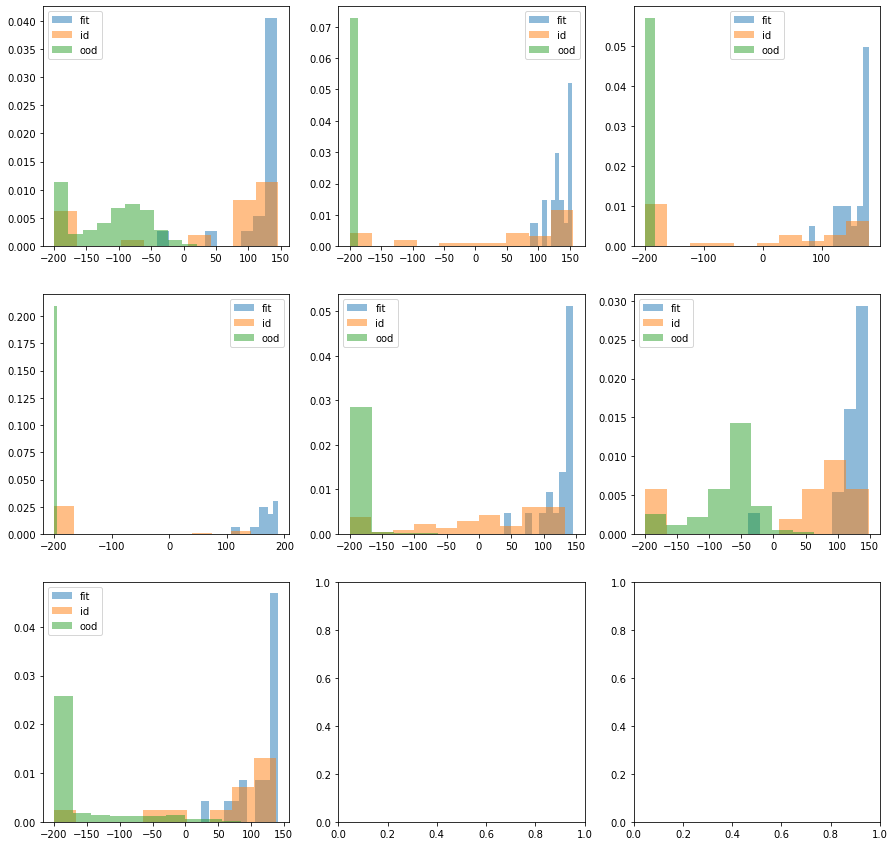

In [77]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
for y in range(pred_fit.size(1)):
    ax = axs.flatten()[y]
    ax.hist(norms[y].log_prob(features_fit[labels_fit == y]).numpy(), density=True, alpha=0.5, label='fit')
    
    norms_id_eval = norms[y].log_prob(features_eval[labels_eval == y]).numpy()
    norms_id_eval[norms_id_eval < -200] = -200
    ax.hist(norms_id_eval, density=True, alpha=0.5, label='id')
    
    norms_eval = norms[y].log_prob(features_eval[labels_eval >= pred_eval.size(1)]).numpy()
    norms_eval[norms_eval < -200] = -200
    
    ax.hist(norms_eval, density=True, alpha=0.5, label='ood')
    ax.legend()
    

In [15]:
pcafit = PCA(2)
features_fit_proj = pcafit.fit_transform(features_fit.numpy())
features_eval_proj_fit = pcafit.transform(features_eval.numpy())

tensor([0.0026, 0.2308, 0.1460, 0.2361, 0.3034, 0.2023, 0.2083, 0.0147, 0.0048,
        0.0125, 0.2757, 0.2297, 0.0141, 0.0140, 0.0178, 0.1978, 0.0124, 0.2678,
        0.0072, 0.0123, 0.0125, 0.0048, 0.1536, 0.2630, 0.0076, 0.2742, 0.0041,
        0.0121, 0.2837, 0.0126, 0.0054, 0.2633, 0.0135, 0.2023, 0.1925, 0.1831,
        0.0114, 0.2177, 0.0057, 0.0110, 0.2064, 0.0261, 0.1725, 0.2616, 0.0182,
        0.1981, 0.0040, 0.1547, 0.0164, 0.0354, 0.0222, 0.2434, 0.2375, 0.1195,
        0.1872, 0.0187, 0.1865, 0.0093, 0.0143, 0.0065, 0.0108, 0.2259, 0.0065,
        0.2121])

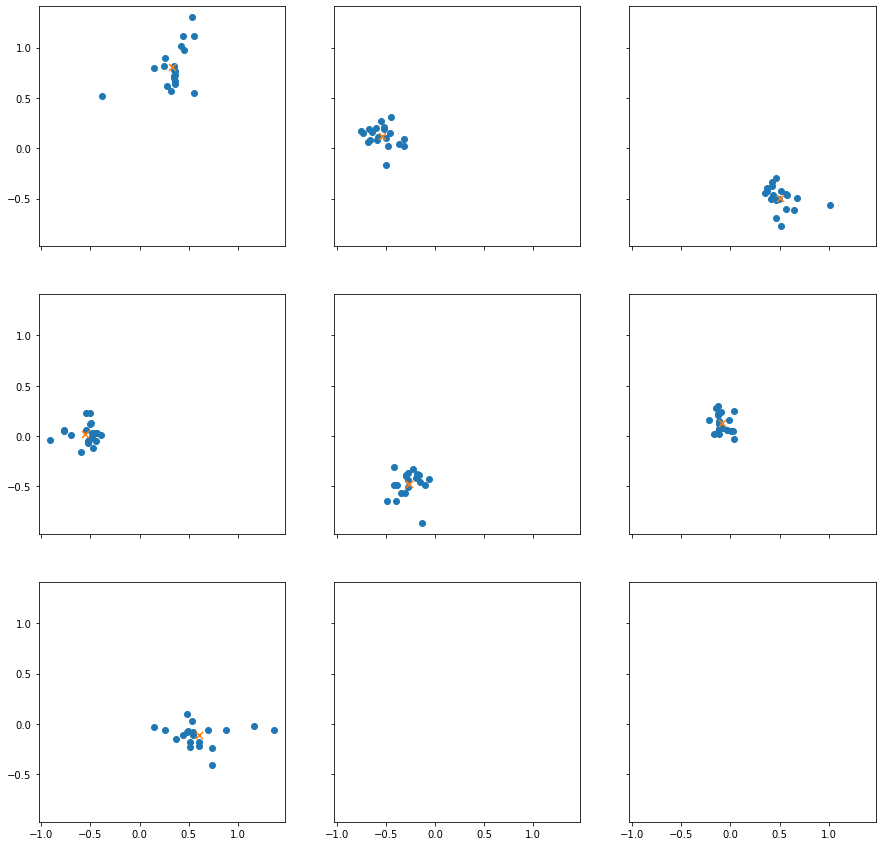

In [107]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
for y in range(pred_fit.size(1)):
    mean = pcafit.transform(means[y].reshape((1, -1)))
    axs.flatten()[y].scatter(features_fit_proj[labels_fit == y][:, 0], features_fit_proj[labels_fit == y][:, 1])
    axs.flatten()[y].scatter(mean[:, 0], mean[:, 1], marker='x', s=50)
    

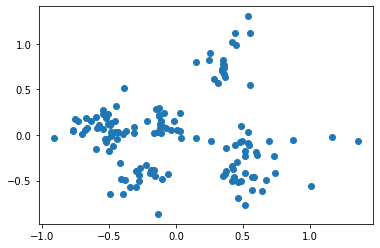

In [19]:
plt.scatter(features_fit_proj[:, 0], features_fit_proj[:, 1])